In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm as tqdm
import pandas as pd
import os
import time

from distance import levenshtein      
from sklearn.cluster import dbscan

import import_ipynb
import data_transformation
import unittest
from sklearn.model_selection import train_test_split 

importing Jupyter notebook from data_transformation.ipynb


In [2]:
data_class = data_transformation.data_transformation(path_data = "/data/data_curated_20180219/curated_training_data_no_mass_spec.csv",
                                                     path_mhc = "/data/aligned_mhc_dataset.csv",
                                                     allele_name = None,
                                                     quant_data = True,
                                                     encoding = "one-hot",
                                                     dbscan = False)

pep, mhc, target = data_class.__getitem__()

pep = np.expand_dims(pep, axis=1)
mhc = np.expand_dims(mhc, axis=1)
inp = np.hstack((pep, mhc))
print(inp.shape)

X_train, X_test, y_train, y_test = train_test_split(inp, target.T, test_size=0.2, random_state=42)

(137377, 2, 34, 20)


## Train and Test set have same distribution of the target values

(array([2.2000e+01, 5.6100e+02, 4.8570e+04, 1.9681e+04, 1.7273e+04,
        1.3543e+04, 7.4100e+03, 2.5370e+03, 2.9500e+02, 9.0000e+00]),
 array([-1.43017093, -1.21535945, -1.00054797, -0.7857365 , -0.57092502,
        -0.35611354, -0.14130206,  0.07350942,  0.2883209 ,  0.50313238,
         0.71794386]),
 <a list of 10 Patch objects>)

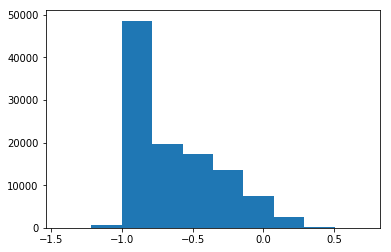

In [3]:
plt.hist(y_train.flatten())

(array([2.1000e+01, 1.5730e+03, 1.2146e+04, 4.8900e+03, 3.8830e+03,
        2.9350e+03, 1.6540e+03, 3.5800e+02, 1.3000e+01, 3.0000e+00]),
 array([-1.34103584, -1.13275871, -0.92448158, -0.71620445, -0.50792732,
        -0.29965019, -0.09137306,  0.11690408,  0.32518121,  0.53345834,
         0.74173547]),
 <a list of 10 Patch objects>)

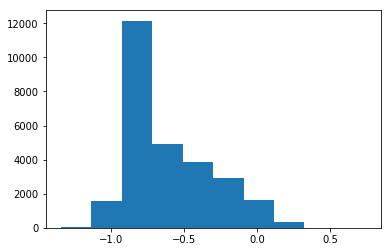

In [4]:
plt.hist(y_test.flatten())

## Naive Model taking only the mean value lead to RMSE of 0.3

In [5]:
pred = np.full(len(y_test.flatten()), np.mean(y_test.flatten()))

In [6]:
error = pred - y_test.flatten()
error2 = np.square(error)
rmse = np.sqrt(np.mean(error2))
rmse

0.2928557865457815

## Comparision of input values of test and train set

In [7]:
results_max = []
for j in tqdm(range(100)):#len(X_train))):
    a = X_train[j, 0][~np.all(X_train[j, 0] == 0, axis=1)]
    mhc_a = X_train[j, 1][~np.all(X_train[j, 1] == 0, axis=1)]
    results = []
    for i in range(len(X_test)):
        b = X_test[i, 0][~np.all(X_test[i, 0] == 0, axis=1)]
        mhc_b = X_test[i, 1][~np.all(X_test[i, 1] == 0, axis=1)]
        #print(b.size)
        if mhc_a.size == mhc_b.size: #here for now easier looping
            if a.size > b.size:
                temp_b = np.zeros(a.shape)
                temp_b[:b.shape[0],:b.shape[1]] = b
                temp = np.sum(np.all(a == temp_b, axis=1))
            elif a.size < b.size:
                temp_a = np.zeros(b.shape)
                temp_a[:a.shape[0],:a.shape[1]] = a
                temp = np.sum(np.all(temp_a == b, axis=1))
            else:
                temp = np.sum(np.all(a == b, axis=1))
            temp_mhc = np.sum(np.all(mhc_a == mhc_b, axis=1))
            if a.shape[1] >= b.shape[1]:
                results.append([temp / a.shape[0], temp_mhc / mhc_a.shape[0]])
            else:
                results.append([temp / b.shape[0], temp_mhc / mhc_a.shape[0]])
    #print(results)
    results_max.append(max(np.mean(results, axis = 1)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


(array([ 3.,  0.,  3.,  0., 10.,  5.,  3., 10.,  6.,  9.,  7.,  4.,  6.,
         4.,  8.,  1.,  2., 12.,  3.,  4.]),
 array([0.65  , 0.6675, 0.685 , 0.7025, 0.72  , 0.7375, 0.755 , 0.7725,
        0.79  , 0.8075, 0.825 , 0.8425, 0.86  , 0.8775, 0.895 , 0.9125,
        0.93  , 0.9475, 0.965 , 0.9825, 1.    ]),
 <a list of 20 Patch objects>)

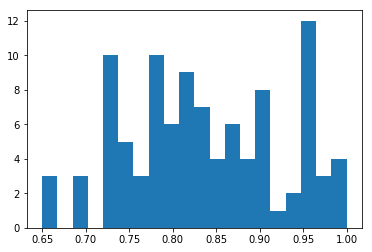

In [8]:
plt.hist(results_max, bins = 20)

(array([ 3.,  0.,  3.,  0., 10.,  5.,  3., 10.,  6.,  9.,  7.,  4.,  6.,
         4.,  8.,  1.,  2., 12.,  3.,  4.]),
 array([0.65  , 0.6675, 0.685 , 0.7025, 0.72  , 0.7375, 0.755 , 0.7725,
        0.79  , 0.8075, 0.825 , 0.8425, 0.86  , 0.8775, 0.895 , 0.9125,
        0.93  , 0.9475, 0.965 , 0.9825, 1.    ]),
 <a list of 20 Patch objects>)

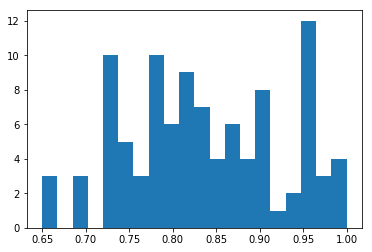

In [9]:
plt.hist(results_max, bins = 20)

## Order Pandas by levensthein distance

In [12]:
cwd = os.getcwd()
os.chdir('..')
os.chdir('..')
os.chdir('..')
current_path = os.getcwd()
dfcl = pd.read_csv(current_path + "/data/data_curated_20180219/curated_training_data_no_mass_spec.csv")
os.chdir(cwd) 
df = dfcl[dfcl.measurement_type == "quantitative"].loc[:, ['peptide', 'allele']].drop_duplicates().reset_index(drop = True)

In [3]:
df.head()

,peptide,allele
0,AENDTLVVSV,BoLA-1*21:01
1,NQFNGGCLLV,BoLA-1*21:01
2,AAHCIHAEW,BoLA-2*08:01
3,AAKHMSNTY,BoLA-2*08:01
4,DSYAYMRNGW,BoLA-2*08:01


In [ ]:
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(t[i], t[j])

grouping = df.groupby('allele')
list_values = []

for name, group in tqdm(grouping):
    df_test = df[df.allele == name].reset_index(drop = True)
    t = df_test.peptide.values
    X = np.arange(len(t)).reshape(-1, 1)
    #start = time.time()
    te = dbscan(X, metric=lev_metric, eps=4, min_samples=2, algorithm='brute')
    #end = time.time()
    #print(end - start)

    d = {'name_allele': np.repeat(name,te[1].shape[0]), 'name_peptide': t, 'dbscan_cluster': te[1]}
    list_values.append(d)
    
df_cluster = pd.concat([pd.DataFrame(l) for l in list_values],axis=0)

In [10]:
df_cluster.shape

(158963, 3)

In [8]:
df_cluster[df_cluster.dbscan_cluster == -1].shape

(58543, 3)

In [18]:
merge_df = pd.merge(dfcl, df_cluster, left_on = ["allele", "peptide"], right_on = ["name_allele", 'name_peptide'], how='left').drop(['name_peptide', 'name_allele'], axis = 1)

In [19]:
merge_df.to_csv("C:/Users/paul_/OneDrive/Desktop/master-thesis/data/data_curated_20180219/curated_training_data_no_mass_spec_dbscan.csv")

## Test DBSCAN split

In [2]:
data_class = data_transformation.data_transformation(path_data = "/data/data_curated_20180219/curated_training_data_no_mass_spec_dbscan.csv",
                                                     path_mhc = "/data/aligned_mhc_dataset.csv",
                                                     allele_name = None,
                                                     quant_data = True,
                                                     encoding = "one-hot")

pep, mhc, target, dbscan = data_class.__getitem__()

pep = np.expand_dims(pep, axis=1)
mhc = np.expand_dims(mhc, axis=1)
inp = np.hstack((pep, mhc))
print(inp.shape)

np.random.seed(17) 
test_index = np.random.choice(np.where(dbscan.T == -1)[0],
                              size = int(np.round(dbscan.T.shape[0] * 0.2)),
                              replace = False)

X_train = inp[~np.isin(np.arange(len(inp)), test_index)]
X_test = inp[np.isin(np.arange(len(inp)), test_index)]
y_train = target.T[~np.isin(np.arange(len(target.T)), test_index)]
y_test = target.T[np.isin(np.arange(len(target.T)), test_index)]

(137377, 2, 34, 20)


In [3]:
X_train.shape

(109902, 2, 34, 20)

In [4]:
X_test.shape

(27475, 2, 34, 20)

In [5]:
y_train.shape

(109902, 1)

In [6]:
y_test.shape

(27475, 1)

(-1.5, 0.75)

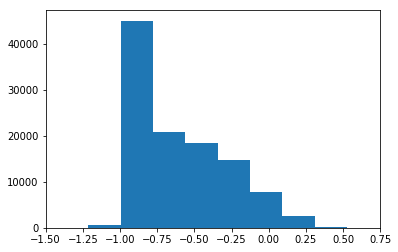

In [7]:
plt.hist(y_train.flatten())
plt.xlim(-1.5, 0.75)

(-1.5, 0.75)

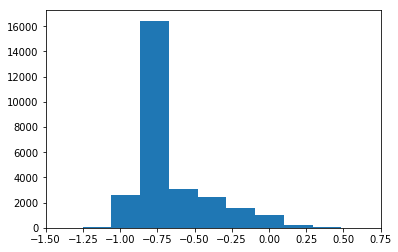

In [8]:
plt.hist(y_test.flatten())
plt.xlim(-1.5, 0.75)

In [9]:
results_max = []
for j in tqdm(range(500)):#len(X_train))):
    a = X_train[j, 0][~np.all(X_train[j, 0] == 0, axis=1)]
    mhc_a = X_train[j, 1][~np.all(X_train[j, 1] == 0, axis=1)]
    results = []
    for i in range(len(X_test)):
        b = X_test[i, 0][~np.all(X_test[i, 0] == 0, axis=1)]
        mhc_b = X_test[i, 1][~np.all(X_test[i, 1] == 0, axis=1)]
        #print(b.size)
        if mhc_a.size == mhc_b.size: #here for now easier looping
            if a.size > b.size:
                temp_b = np.zeros(a.shape)
                temp_b[:b.shape[0],:b.shape[1]] = b
                temp = np.sum(np.all(a == temp_b, axis=1))
            elif a.size < b.size:
                temp_a = np.zeros(b.shape)
                temp_a[:a.shape[0],:a.shape[1]] = a
                temp = np.sum(np.all(temp_a == b, axis=1))
            else:
                temp = np.sum(np.all(a == b, axis=1))
            temp_mhc = np.sum(np.all(mhc_a == mhc_b, axis=1))
            if a.shape[1] >= b.shape[1]:
                results.append([temp / a.shape[0], temp_mhc / mhc_a.shape[0]])
            else:
                results.append([temp / b.shape[0], temp_mhc / mhc_a.shape[0]])
    #print(results)
    results_max.append(max(np.mean(results, axis = 1)))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [33:47<00:00,  2.03s/it]


(array([  1.,   7.,  13., 142.,   7.,  52., 396., 113.,  51., 162.,   2.,
         16.,   2.,   4.,  29.,   2.,   0.,   0.,   0.,   1.]),
 array([0.56985294, 0.58547794, 0.60110294, 0.61672794, 0.63235294,
        0.64797794, 0.66360294, 0.67922794, 0.69485294, 0.71047794,
        0.72610294, 0.74172794, 0.75735294, 0.77297794, 0.78860294,
        0.80422794, 0.81985294, 0.83547794, 0.85110294, 0.86672794,
        0.88235294]),
 <a list of 20 Patch objects>)

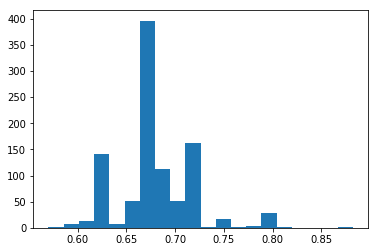

In [10]:
plt.hist(results_max, bins = 20)

(array([  1.,   7.,  13., 142.,   7.,  52., 396., 113.,  51., 162.,   2.,
         16.,   2.,   4.,  29.,   2.,   0.,   0.,   0.,   1.]),
 array([0.56985294, 0.58547794, 0.60110294, 0.61672794, 0.63235294,
        0.64797794, 0.66360294, 0.67922794, 0.69485294, 0.71047794,
        0.72610294, 0.74172794, 0.75735294, 0.77297794, 0.78860294,
        0.80422794, 0.81985294, 0.83547794, 0.85110294, 0.86672794,
        0.88235294]),
 <a list of 20 Patch objects>)

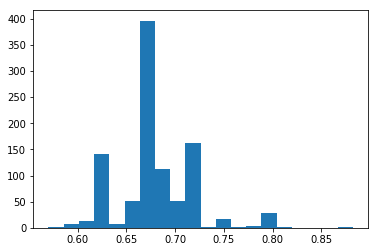

In [11]:
plt.hist(results_max, bins = 20)